In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

In [193]:
import subprocess

img1_path = 'image1.jpg'
img2_path = 'image2.jpg'
bin_path = './sift-project/sift'

try:
    subprocess.run([bin_path, img1_path, img2_path])
except Exception as e:
    print(e)

Initial image computed: 1510x998
Octaves count: 8
Gaussian kernels: [ 1.6 1.22627 1.54501 1.94659 2.45255 3.09002 ]
Computing Gaussian images...
Computing octave 0/8...
Resizing image...
Image resized. New dimensions: 755x499
Computing octave 1/8...
Resizing image...
Image resized. New dimensions: 377x249
Computing octave 2/8...
Resizing image...
Image resized. New dimensions: 188x124
Computing octave 3/8...
Resizing image...
Image resized. New dimensions: 94x62
Computing octave 4/8...
Resizing image...
Image resized. New dimensions: 47x31
Computing octave 5/8...
Resizing image...
Image resized. New dimensions: 23x15
Computing octave 6/8...
Resizing image...
Image resized. New dimensions: 11x7
Computing octave 7/8...
Resizing image...
Image resized. New dimensions: 5x3
Gaussian images computed!
Computing DoG images...
Finished DoG octave 0/8...
Finished DoG octave 1/8...
Finished DoG octave 2/8...
Finished DoG octave 3/8...
Finished DoG octave 4/8...
Finished DoG octave 5/8...
Finished

In [195]:
matches = np.genfromtxt('./sift-project/matches.csv', delimiter=',').astype(int)
matches[:10]

array([[462, 326,   4, 323],
       [468, 260,  11, 257],
       [469, 425,  12, 422],
       [470, 449,  13, 446],
       [470, 449,  13, 446],
       [470, 270,  13, 267],
       [472, 232,  15, 228],
       [473, 272,  16, 269],
       [476, 419,  19, 417],
       [482, 278,  24, 275]])

In [196]:
def plot_matches(matches, img1, img2):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    ax.imshow(np.hstack((img1, img2)), cmap='gray')
    for match in matches:
        ax.plot([match[0], match[2] + img1.shape[1]], [match[1], match[3]], 'r-', lw=0.5)
    plt.axis('off')
    plt.show()

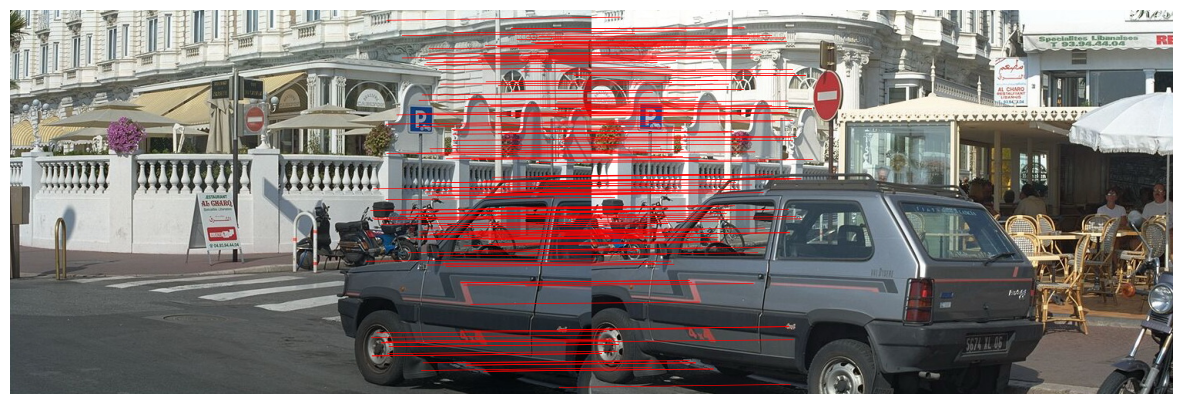

In [197]:
img1 = plt.imread(img1_path)
img2 = plt.imread(img2_path)

plot_matches(matches, img1, img2)

In [ ]:
def compute_homography(matches):
    if len(matches) < 4:
        return None

    A = []
    for match in matches:
        x1, y1, x2, y2 = match
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    
    return H

def ransac(matches, max_iter=1000, threshold=5, p=0.99):
    best_H = None
    best_inliers = []
    
    i = 0
    N_iter = max_iter
    while i < N_iter:
        sample = matches[np.random.choice(len(matches), 4, replace=False)]
        H = compute_homography(sample)
        if H is None:
            continue
        
        inliers = []
        for match in matches:
            x1, y1, x2, y2 = match
            p1 = np.array([x1, y1, 1])
            p2 = np.array([x2, y2, 1])
            p2_ = np.dot(H, p1)
            p2_ /= p2_[-1]
            if np.linalg.norm(p2_ - p2) < threshold:
                inliers.append(match)
        
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
            
            inliers_prop = len(inliers) / len(matches)
            N_iter = np.log(1 - p) / np.log(1 - inliers_prop**4)
            N_iter = int(np.ceil(N_iter))
        i += 1
    
    # Refit the model using all inliers
    best_H = compute_homography(best_inliers)
    
    return best_H, best_inliers

In [3]:
def warp_perspective(img, H, output_shape, offset):
    """
    Warp img using the homography matrix H to the desired output shape.
    """
    h, w = output_shape
    warped_img = np.zeros((h, w, 3), dtype=np.uint8)

    off_x, off_y = offset
    H_inv = np.linalg.inv(H)
    for y in range(h):
        for x in range(w):
            homogenous_coords = np.array([x-off_x, y-off_y, 1])
            
            src_coords = np.dot(H_inv, homogenous_coords)
            src_x = round(src_coords[0] / src_coords[2])
            src_y = round(src_coords[1] / src_coords[2])
            
            if 0 <= src_x < img.shape[1] and 0 <= src_y < img.shape[0]:
                warped_img[y, x] = img[int(src_y), int(src_x)]
    
    return warped_img

def apply_stitching(img1, img2, H):
    """
    Stitch two images together using the homography matrix H.
    """
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape
    
    corners_img1 = np.array([[0, 0, 1], [w1, 0, 1], [w1, h1, 1], [0, h1, 1]]).T
    warped_corners = np.dot(H, corners_img1)
    warped_corners /= warped_corners[2, :]
    
    min_x = int(np.floor(np.min(warped_corners[0, :])))
    max_x = int(np.ceil(np.max(warped_corners[0, :])))
    min_y = int(np.floor(np.min(warped_corners[1, :])))
    max_y = int(np.ceil(np.max(warped_corners[1, :])))
    
    offset_x = -min_x if min_x < 0 else 0
    offset_y = -min_y if min_y < 0 else 0
    
    min_x = min(0, min_x)
    min_y = min(0, min_y)
    max_x = max(max_x, w2)
    max_y = max(max_y, h2)
    
    result_width = max_x - min_x
    result_height = max_y - min_y

    result_img = np.zeros((result_height, result_width, 3), dtype=np.uint8)
    result_img[offset_y:offset_y + h2, offset_x:offset_x + w2] = img2
    
    warped_img1 = warp_perspective(img1, H, (result_height, result_width), (offset_x, offset_y))
    
    mask = warped_img1 > 0
    result_img[mask] = warped_img1[mask]
    
    return result_img

In [200]:
H, best_inliers = ransac(matches, threshold=1, p=0.99)
print("Number of inliers:", len(best_inliers))
print("Homography matrix:")
print(H)

Number of inliers: 103
Homography matrix:
[[ 2.19529522e-03 -2.86517768e-05 -9.99655760e-01]
 [ 3.70552912e-05  2.16701856e-03 -2.59696983e-02]
 [ 1.13585833e-07  1.97410834e-08  2.10196685e-03]]


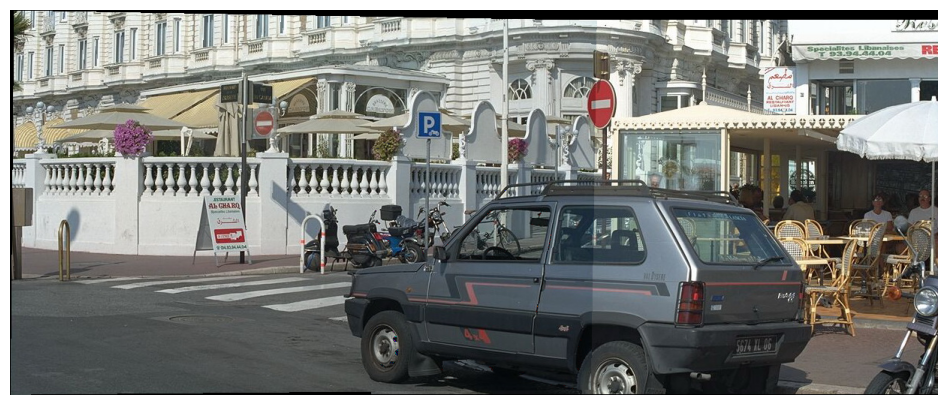

In [201]:
stitched = apply_stitching(img1, img2, H)

plt.figure(figsize=(15, 5))
plt.imshow(stitched)
plt.axis('off')
plt.show()

## Scene auto-collage

In [4]:
import cv2


def match_keypoints(kp1, desc1, kp2, desc2, ratio_threshold=0.5):
    matches = []

    distances = np.linalg.norm(desc1[:, np.newaxis] - desc2, axis=2)

    best_indices = np.argsort(distances, axis=1)[:, :2]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    for i, (best_dist, second_best_dist) in enumerate(best_distances):
        if best_dist < ratio_threshold * second_best_dist:
            best_index = best_indices[i, 0]
            matches.append([int(round(kp1[i].pt[0])), int(round(kp1[i].pt[1])),
                            int(round(kp2[best_index].pt[0])), int(round(kp2[best_index].pt[1]))])

    return np.array(matches)

def stitch_collection(collection_path, limit=None, max_size=1000):
    # detect case non sensitive
    imgs_path = glob.glob(os.path.join(collection_path, '*.jpg'))
    imgs_path.sort()
    imgs = [plt.imread(img_path) for img_path in imgs_path]
    
    height, width, _ = imgs[0].shape
    if max(height, width) > max_size:
        scale = max_size / max(height, width)
        imgs = [cv2.resize(img, None, fx=scale, fy=scale) for img in imgs]

    stitched = imgs[0]
    limit = len(imgs) if limit is None else limit
    for i in range(1, limit):
        print()
        print(f"Processing image {i}...")
        img1 = cv2.cvtColor(stitched, cv2.COLOR_RGB2GRAY)
        img2 = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2GRAY)

        sift = cv2.SIFT_create()
        kp1, desc1 = sift.detectAndCompute(img1, None)
        kp2, desc2 = sift.detectAndCompute(img2, None)

        matches = match_keypoints(kp1, desc1, kp2, desc2)

        H, best_inliers = ransac(matches, threshold=1, p=0.99)
        print(f"Number of inliers: {len(best_inliers)}/{len(matches)}")
        print("Homography matrix:", H)

        stitched = apply_stitching(stitched, imgs[i], H)
    
    return stitched
        

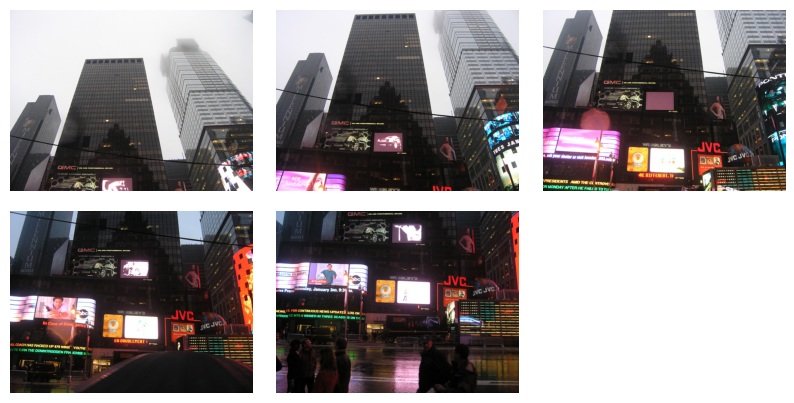

In [5]:
collection_imgs_path = "./collection/Dataset/CAVE-04_times_square/"

imgs_path = glob.glob(os.path.join(collection_imgs_path, '*.jpg'))
imgs_path.sort()
imgs = [plt.imread(img_path) for img_path in imgs_path[:5]]

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


Processing image 1...
Number of inliers: 164/323
Homography matrix: [[-7.65373590e-03 -7.48369071e-04  1.00524958e-01]
 [-7.78480380e-05 -8.13073829e-03  9.94846760e-01]
 [ 1.60935851e-07 -2.50201199e-06 -7.02874194e-03]]

Processing image 2...
Number of inliers: 70/161
Homography matrix: [[ 3.53686317e-03  3.87396534e-04 -1.64719847e-01]
 [ 2.18689432e-05  3.78551324e-03 -9.86321844e-01]
 [-9.90918024e-08  1.18660563e-06  3.09875280e-03]]

Processing image 3...
Number of inliers: 92/182
Homography matrix: [[-2.24487232e-03 -1.57851503e-04  1.57194013e-01]
 [ 1.25618331e-05 -2.38087930e-03  9.87560268e-01]
 [ 1.27082901e-07 -5.47136709e-07 -2.00634686e-03]]

Processing image 4...
Number of inliers: 49/105
Homography matrix: [[-1.51811526e-03 -1.15622717e-04  1.86694041e-01]
 [-3.81423529e-06 -1.57487464e-03  9.82414832e-01]
 [ 1.22229485e-08 -3.07160271e-07 -1.27853736e-03]]


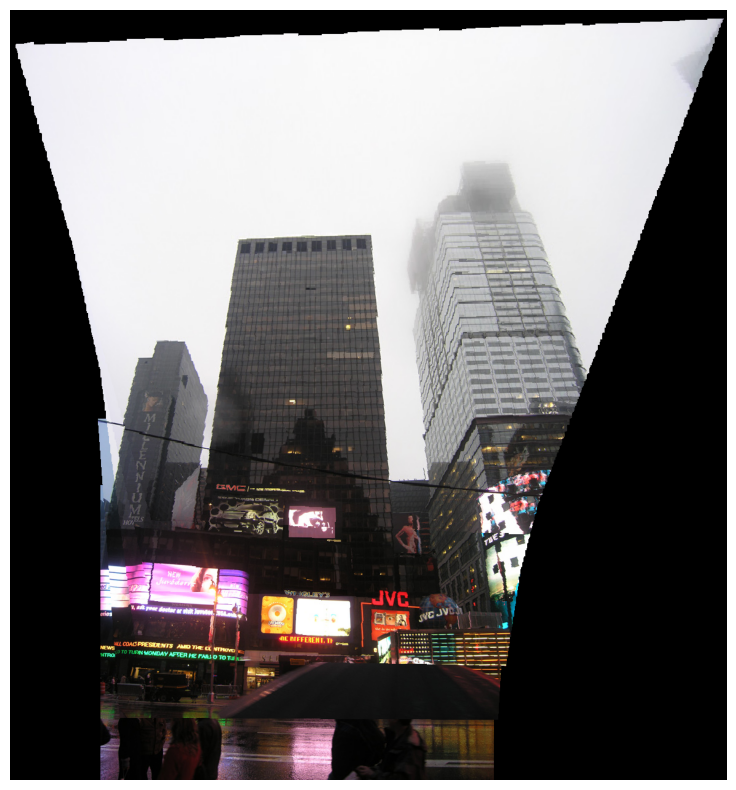

Final shape: (1253, 1166, 3)


In [ ]:
stitched = stitch_collection(collection_imgs_path, limit=5)

plt.figure(figsize=(10, 10))
plt.imshow(stitched)
plt.axis('off')
plt.show()

print(f"Final shape: {stitched.shape}")

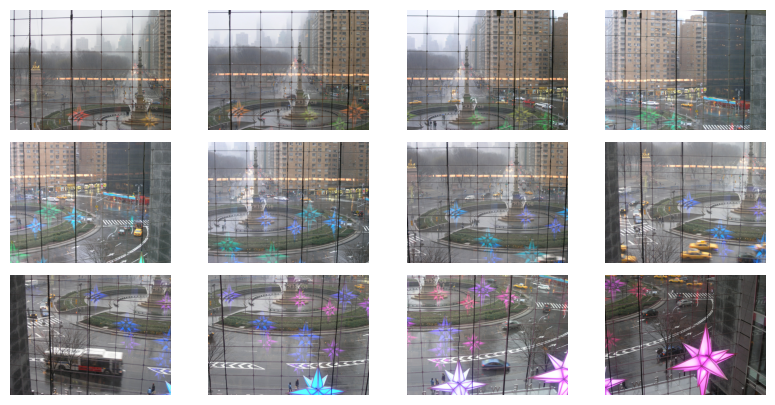

In [6]:
collection_imgs_path = "./collection/Dataset/CAVE-01_atrium/"

imgs_path = glob.glob(os.path.join(collection_imgs_path, '*.jpg'))
imgs_path.sort()
imgs = [plt.imread(img_path) for img_path in imgs_path[:12]]

fig, axes = plt.subplots(3, 4, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


Processing image 1...
Number of inliers: 125/222
Homography matrix: [[ 6.26993533e-03  4.29018721e-05 -9.88700473e-01]
 [ 7.38563722e-05  6.17073628e-03 -1.49527881e-01]
 [ 4.39013264e-07  9.61062574e-08  5.94892780e-03]]

Processing image 2...
Number of inliers: 169/277
Homography matrix: [[ 3.36477339e-03 -1.64290896e-06 -9.98890848e-01]
 [ 3.59055595e-05  3.30651712e-03 -4.67382214e-02]
 [ 1.89248801e-07 -1.53387145e-08  3.21825709e-03]]

Processing image 3...
Number of inliers: 64/110
Homography matrix: [[ 1.67244424e-03  9.14131781e-06 -9.98948798e-01]
 [ 4.15153319e-05  1.61510076e-03 -4.57585665e-02]
 [ 2.51000925e-07 -2.04367259e-08  1.42986731e-03]]

Processing image 4...
Number of inliers: 36/73
Homography matrix: [[ 1.32211878e-03  3.76194453e-05 -9.71341003e-01]
 [-1.38178627e-06  1.31602001e-03 -2.37679700e-01]
 [ 3.59576970e-08  8.93623418e-08  1.23897621e-03]]

Processing image 5...
Number of inliers: 32/78
Homography matrix: [[ 1.93956569e-03 -1.19085386e-04 -9.2445378

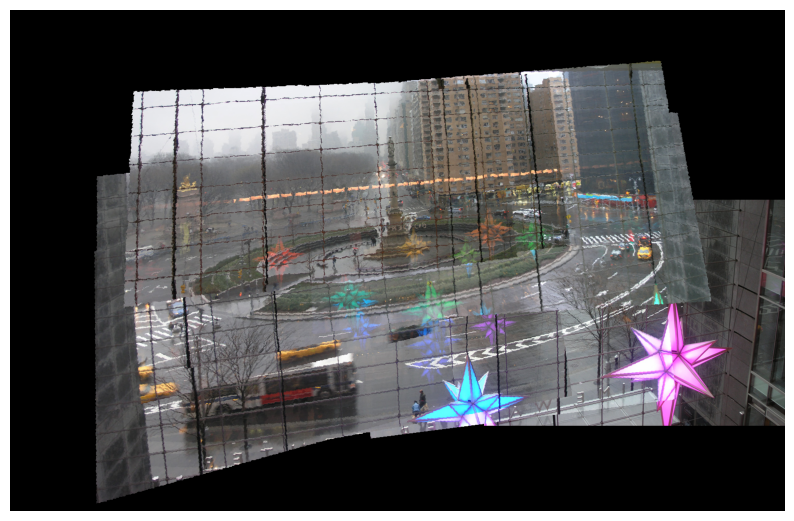

Final shape: (1066, 1648, 3)


In [14]:
collection_imgs_path = "./collection/Dataset/CAVE-01_atrium/"
stitched = stitch_collection(collection_imgs_path, limit=12)

plt.figure(figsize=(10, 10))
plt.imshow(stitched)
plt.axis('off')
plt.show()

print(f"Final shape: {stitched.shape}")

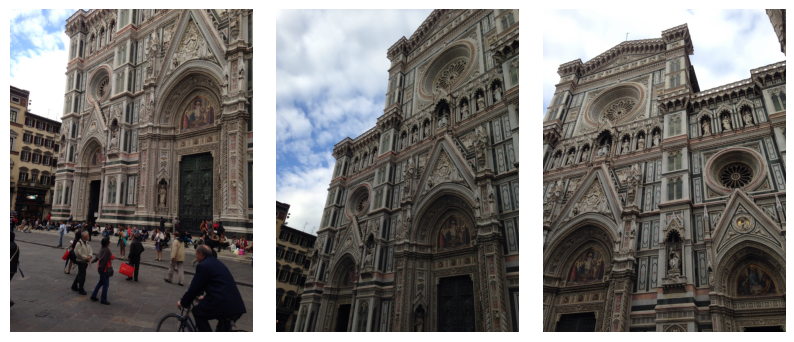

In [7]:
collection_imgs_path = "./collection/Dataset/NISwGSP-02_SantaMaria-all/"

imgs_path = glob.glob(os.path.join(collection_imgs_path, '*.jpg'))
imgs_path.sort()
imgs = [plt.imread(img_path) for img_path in imgs_path[:3]]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


Processing image 1...
Number of inliers: 95/229
Homography matrix: [[ 3.55052604e-03 -7.61044179e-04  8.80298318e-02]
 [ 2.53982554e-04  2.38588359e-03  9.96100082e-01]
 [ 2.07276245e-07 -2.74157208e-06  4.05377420e-03]]

Processing image 2...
Number of inliers: 62/151
Homography matrix: [[-2.67217976e-03  5.70652431e-04  9.26870842e-01]
 [-1.17024249e-03 -2.18748929e-03  3.75358475e-01]
 [-1.92946990e-06  7.35718991e-07 -1.68440697e-03]]


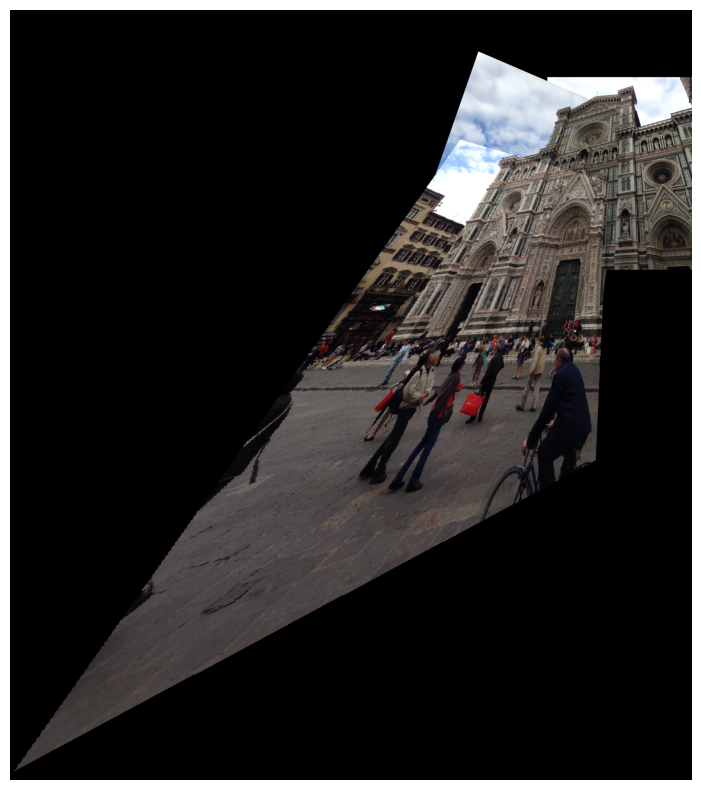

Final shape: (2558, 2263, 3)


In [7]:
collection_imgs_path = "./collection/Dataset/NISwGSP-02_SantaMaria-all/"
stitched = stitch_collection(collection_imgs_path, limit=3, max_size=640)

plt.figure(figsize=(10, 10))
plt.imshow(stitched)
plt.axis('off')
plt.show()

print(f"Final shape: {stitched.shape}")

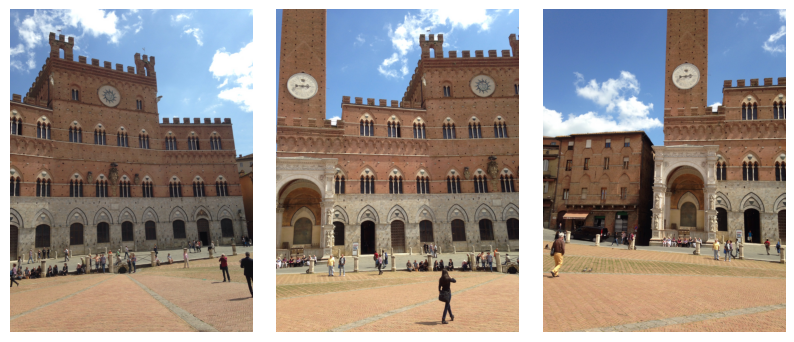

In [8]:
collection_imgs_path = "./collection/Dataset/NISwGSP-06_PalazzoPubblico/"

imgs_path = glob.glob(os.path.join(collection_imgs_path, '*.jpg'))
imgs_path.sort()
imgs = [plt.imread(img_path) for img_path in imgs_path[:3]]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


Processing image 1...
Number of inliers: 35/94
Homography matrix: [[-3.09971836e-03 -1.60376652e-04 -9.89024734e-01]
 [ 1.27404855e-03 -4.10458967e-03 -1.47582339e-01]
 [ 3.12324246e-06  2.44203935e-07 -4.62853032e-03]]

Processing image 2...
Number of inliers: 48/109
Homography matrix: [[-2.52111523e-03 -2.19696701e-04 -8.23011362e-01]
 [ 9.17356845e-04 -3.66554493e-03  5.67994748e-01]
 [ 2.78702206e-06 -4.21215272e-07 -3.68548468e-03]]


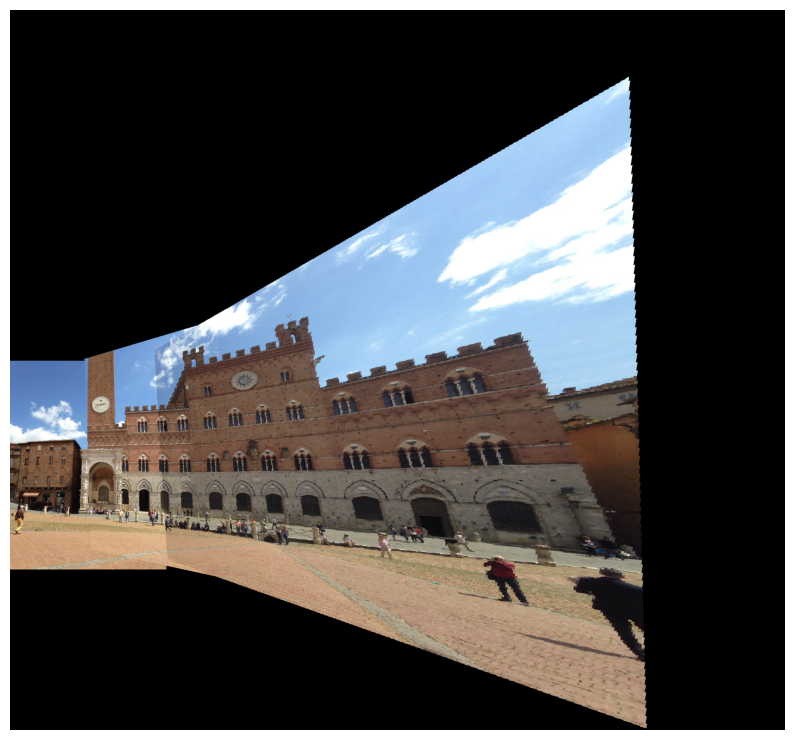

(2210, 2378, 3)

In [ ]:
collection_imgs_path = "./collection/Dataset/NISwGSP-06_PalazzoPubblico/"
stitched = stitch_collection(collection_imgs_path, limit=3, max_size=640)

plt.figure(figsize=(10, 10))
plt.imshow(stitched)
plt.axis('off')
plt.show()

print(f"Final shape: {stitched.shape}")

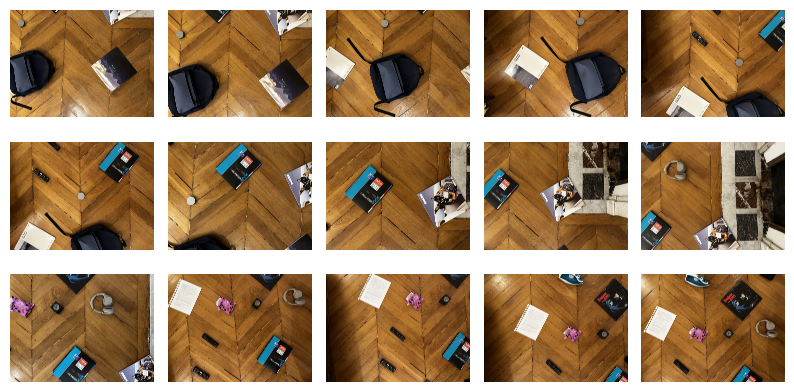

In [9]:
collection_imgs_path = "./collection/own/"

imgs_path = glob.glob(os.path.join(collection_imgs_path, '*.jpg'))
imgs_path.sort()
imgs = [plt.imread(img_path) for img_path in imgs_path[:15]]

fig, axes = plt.subplots(3, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [5]:
collection_imgs_path = "./collection/own/"
stitched = stitch_collection(collection_imgs_path, limit=15, max_size=950)
print(f"Final shape: {stitched.shape}")


Processing image 1...
Number of inliers: 94/214
Homography matrix: [[ 1.79859774e-02  1.00946738e-04 -5.22731050e-02]
 [ 3.01178181e-05  1.73931067e-02  9.98192344e-01]
 [ 5.47872269e-07 -5.55140778e-07  1.59229196e-02]]

Processing image 2...
Number of inliers: 14/25
Homography matrix: [[-3.27303445e-03 -7.81567629e-05 -9.69134028e-01]
 [-8.74643687e-05 -3.32841725e-03  2.46468607e-01]
 [ 2.94096025e-08 -2.39841223e-07 -3.26439596e-03]]

Processing image 3...
Number of inliers: 14/32
Homography matrix: [[-4.10289982e-03  3.48036480e-05 -9.34523086e-01]
 [-3.77591306e-05 -4.02475790e-03  3.55833589e-01]
 [-1.30103628e-07  1.25860217e-07 -4.00302107e-03]]

Processing image 4...
Number of inliers: 20/35
Homography matrix: [[-5.08539204e-03 -3.61500584e-04 -7.34086097e-02]
 [ 2.79136343e-04 -5.60497509e-03 -9.97258333e-01]
 [ 5.41342572e-07 -3.61042884e-07 -5.43212895e-03]]

Processing image 5...
Number of inliers: 32/81
Homography matrix: [[-5.00616465e-03 -5.03278817e-04  9.68045297e-0

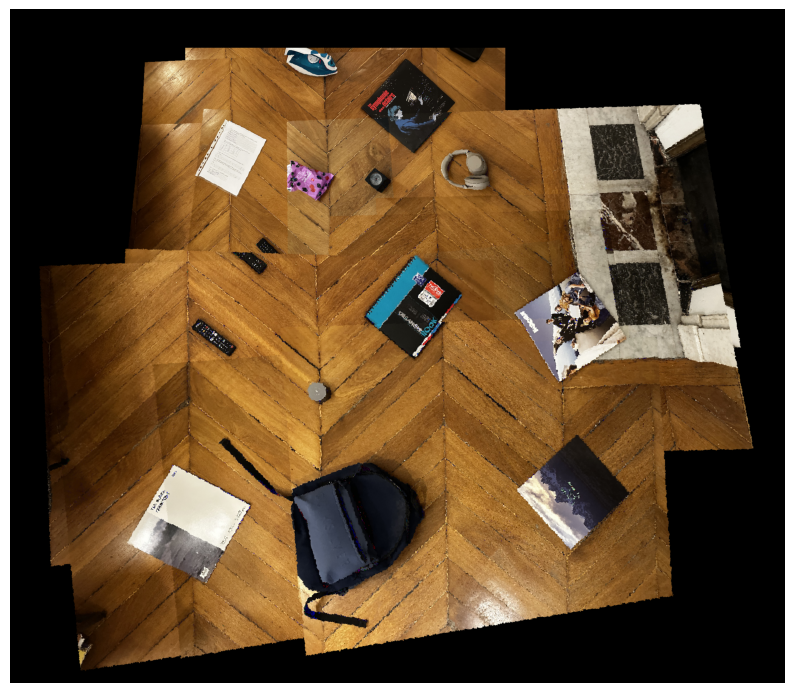

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(stitched[:2000, 700:3000])
plt.axis('off')
plt.show()